# Problem set 2 (40 + 36 + 35 = 111 pts)

In this problem set we also present some bonus problems that will be considered as in Problem Set 1.

## Problem 1. Segmentation. (40 pts)
In this task, you will need to solve the problem of semantic segmentation of the attributes of a person's face. You will work with [CelebAMask-HQ](https://github.com/switchablenorms/CelebAMask-HQ) dataset. You are free to solve and implement required steps on your own. However, there are several constraints and advices:
- To speed up and simplify experiments, you can transform images to 512x512 resolution and use this [train-test split](https://drive.google.com/file/d/1vO4mJ08FMdcom2-sNs4WHxPztIRYrFYI/view?usp=share_link), that has smaller number of images.
- (20 pts) Implement needed train-test pipeline (dataset, model, train and test loops), train and test the model. 
  - (10 pts) Bonus: your own model, not taken from libraries and not a Unet.
- (5 pts) Report IoU and Dice-scores of each class on the test set.
- (5 pts) Try to add augmentations (helpful [link1](https://albumentations.ai/) and [link2](https://kornia.github.io/)).
- (2 pts) Plot 4-6 examples of obtained results on the test set (show the best and the worst according to the loss/metrics).
- (3 pts) Explain why you solved the problem this way and not otherwise, provide description of experiments and their results. Analyze your metrics, are they suitable?
- (5 pts) Make additional function for inference that receives path to the image. Test your model on several photos not from the dataset (pick your own photo or any other from internet). Does your model work well on the new data?
- Do not use already pretrained on CelebAMask-HQ models.
- **Bonus**: 
  - **+10 points** for top-1 result
  - **+8 points** for 2-3 places
  - **+5 points** for 4-8 places 
according to reported mean Dice score on the provided test split.

## Problem 2. Deep image prior (36 pts)

In the deep prior framework, we aim to learn a prior distribution over the parameters $\theta$ of a generative model such that, given some observation $\hat{y}$, we can sample a plausible output $y$ from the learned prior distribution. The goal is to learn a posterior distribution $p(z,\theta|\hat{y})$ over the latent variable $z$ and the parameters $\theta$ such that, given some observation $\hat{y}$ (e.g., an image of a face), we can sample a plausible latent variable $z$ and generate a corresponding output image $y= f_\theta(z)$ that is similar to the observation. The conditional distribution of $y$ given $\hat{y}$ can be written as an integral over $z$ and $\theta$:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(z,\theta|\hat{y})dzd\theta$$

Unfortunately, in practice, it is difficult to compute this integral exactly, since we don't know the conditional distribution $p(y|z,\theta,\hat{y})$ and the posterior distribution $p(z,\theta|\hat{y})$. Instead, we can use an optimization approach to learn the prior distribution $p(z,\theta)$ and the network $f_\theta(z)$ that best approximate the true conditional distribution.

Specifically, we first assume that the latent variable $z$ is independent of the observation $\hat{y}$, i.e., $p(z,\theta|\hat{y}) = p(\theta|\hat{y})p(z)$. This allows us to rewrite the conditional distribution of $y$ as:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Next, we use an optimization approach to learn the parameters $\theta$ of the network to minimize the expected distance between the generated output $y=f_\theta(z)$ and the observation $\hat{y}$:

$$\min_\theta E(f_\theta(z),\hat{y})$$

To perform this optimization, we can apply a stochastic gradient descent approach where we sample random values of $z$ from the prior distribution $p(z)$ and compute the gradients of the loss function with respect to $\theta$ using backpropagation. This way, we can iteratively update the parameters of the network to improve its ability to generate realistic outputs given the observed data.

This approach is used to perform denoising, inpainting and super resolution. The basic architecture for the task is UNet, which we will use in our experiments.

## Implementation

In [ ]:
import torch
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import torchvision
from torchvision import transforms
import gdown
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import TotalVariation as TV

In [ ]:
class Encoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.downsample = torch.nn.MaxPool2d(2)
    def forward(self,x):
        int_out = self.model(x)
        return self.downsample(int_out), int_out

class Decoder_Block(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
    def forward(self,x,enc_x):
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)

In [ ]:
class Unet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block(hidden_size*16,hidden_size*8),
            Decoder_Block(hidden_size*8,hidden_size*4),
            Decoder_Block(hidden_size*4,hidden_size*2),
            Decoder_Block(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
sharing_link = "https://drive.google.com/file/d/1QMZ9_XdFRfj-arUvW_hlG5Mw8vjzTLsU/view?usp=share_link"
gdown.download(url=sharing_link, output="./data.zip", quiet=False, fuzzy=True)
!unzip ./data.zip

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [ ]:
img = transform(Image.open("./data/denoising/F16_GT.png"))[None].to(device)

## Your work starts here

In [ ]:
noise_strength = 0.1
corrupted_img = (img + torch.randn_like(img)*noise_strength).clamp(0,1)

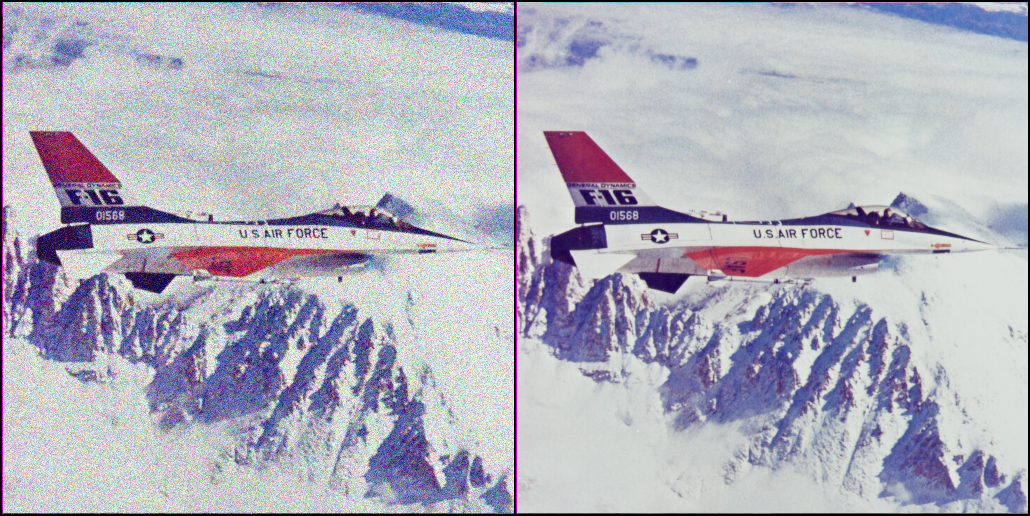

In [ ]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

## Optimization (6 pts)

Task: Implement an optimization function that takes a model, input image, corrupted image, original image, and the number of iterations as arguments.

Steps:

1. Initialize an optimizer (Adam optimizer with learning rate $10^{-4}$).
2. Write a cycle for optimization using the specified loss function (criterion).
3. In each step of the cycle, add a certain amount of noise (reg_noise=0.01) to the input $z$ to ensure computational stability.

**We have provided baseline values for hyperparameters in this and future tasks, but feel free to make adjustments if needed.**

In [ ]:
def optimization(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01):
    # your code is here

### Run the optimization (6 pts):

1. Start by initializing the UNet model with 32 input channels, 3 output channels, and a hidden size of 16.
2. Create a model input of size (1, 32, img.size(2), img.size(3)) by sampling from a normal distribution with a mean of 0 and standard deviation of 0.1.
3. Train the model for 3000 iterations.
4. Plot the training convergence with the loss computed for both generated and corrupted images.
5. Plot the training convergence with the loss computed for both generated and original images.
6. Visualize the results, including the original image, the corrupted image, and the restored image.
7. Explain obtained results (**Hint: look closely at the plot from step 5**)

In [ ]:
# your code is here

## Early stopping (3 pts)

One solution to prevent the recurrence of past issues is by terminating the training process at an optimal point. However, determining the ideal number of iterations can be a challenging task. Therefore, your objective is to:

1. Find out appropriate number of iterations (the best reconstruction of original image)
2. Suggest stopping criteria for the denoising task in real case (when you do not know ground truth) (**Hint: use Total Variation metric to measure the amount of noise in the image**)
3. Compare the result of your strategy with found number of iterations in the first step

In [ ]:
# your code is here, find out appropriate number of iterations

In [ ]:
def optimization_modified(model,z,noised_img,orig_img,iters,criterion=torch.nn.MSELoss()):
    #duplicate your previous code and stop optimization according to stopping criteria

## Stochastic gradient Langevin dynamics (SGLD) optimization 

Another way to solve the problem of increasing the loss function over iterations is to adopt optimization procedure. In the explanations above we have already mentioned that the goal of deep prior is to evaluate the integral:

$$p(y|\hat{y}) = \int p(y|z,\theta,\hat{y})p(\theta|\hat{y})p(z)dzd\theta$$

Instead of directly solving the integral, we can use the Markov chain Monte Carlo (MCMC) method to estimate the posterior. This involves generating a sequence of correlated samples from the target distribution, which can converge to the true posterior during iterations. However, the MCMC approach can be slow and inefficient, and hence, using gradient-based optimization with noise can be a more effective solution. This involves minimizing the objective function and introducing noise to the gradient updates:

$$\theta_{i+1} = \theta_{i} + \mathrm{lr}\cdot\Delta_{i}^{\mathrm{standard}} + s\cdot\mathrm{lr}\cdot\epsilon$$

where $\Delta_{i}^{\mathrm{standard}}$ standard optimization update, $\mathrm{lr}$ - learning rate, $\epsilon \sim N(0,1)$, $s$ - strength of added noise.

More details of how and why it works described in [paper](https://arxiv.org/pdf/1904.07457.pdf)

### Implement SGLD (5 pts)

1. Take the previous implementation of the optimization procedure and adjust it to add noise to the model parameters after each iteration, but **only for convolutional layers**.
2. Set the strength of added noise to 4.
3. Plot the training convergence with the loss computed for generated and corrupted images.
4. Plot the training convergence with the loss computed for generated and original images.
5. Analyze and explain the results in comparison to the Early Stopping approach.
6. Try different values for the strength of added noise $s$ and comment the results.

In [ ]:
def SGLD(model,z,corrupted_img,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.01):
    # your code is here

In [ ]:
# your code is here

## Inpainting

Deep Image Prior is a versatile tool that can be utilized in solving an important task such as image inpainting. In this task, the challenge lies in the inability to obtain values for the pixels that are damaged and defined by the mask. Thus, during the training process, it is essential to apply the mask to the generated image as these values are unavailable for this particular task. Furthermore, in order to effectively address this issue, you will try a more complex model called AttentionUNet. This model is similar to the UNet model in terms of structure but with the inclusion of attention blocks in the decoder part. 

### Attention block (10 pts)

For AttentionUNet implementation you only need to implement Attention layer. Attention should scale hidden output of encoder block which is also an input for the corresponding decoder block in order to draw more "attention" to particular image parts. Below we have placed the pipeline which you should implement:

**Input:** $skip$ of size [batch,skip_channels,H_skip,W_skip], $x$ of size [batch,x_channels,H_x,W_x]

**Output:** $skip^*$ of size [batch,skip_channels,H_skip,W_skip]

1. Apply 2d convolution with kernel size $2$ to $skip$ to make it of size [batch,skip_channels,H_x,W_x] (recall that 2H_x = H_skip, 2W_x = W_skip)
2. Apply 2d convolution with kernel size $1$ to $x$ to make it of size [batch,skip_channels,H_x,W_x]
3. Sum the outputs of previous two steps and apply ReLU over it.
4. Apply 2d convolution to previous output to reduce channel dimension to 1. So the output should have size equal [batch,1,H_x,W_x]
5. Apply Sigmoid to the previous output to get attention itself
6. Apply attention to the input $skip$ (original block input **NOT** the output of the first step) by simply multipling $skip$ by attention element-wise.

In [ ]:
class Attention(torch.nn.Module):
    def __init__(self,skip_channels, x_channels):
        super().__init__()
        # your code is here
    def forward(self,skip,x):
        # your code is here

In [ ]:
class Decoder_Block_With_Attention(torch.nn.Module):
    def __init__(self,inp_channels,out_channels):
        super().__init__()
        self.upsample = torch.nn.ConvTranspose2d(inp_channels,out_channels,kernel_size=2,stride=2)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(inp_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
        )
        self.attention = Attention(out_channels,inp_channels)
    def forward(self,x,enc_x):
        enc_x = self.attention(enc_x,x)
        x = self.upsample(x)
        x = torch.cat([x,enc_x],dim=1)
        return self.model(x)


class AttentionUnet(torch.nn.Module):
    def __init__(self,inc,outc,hidden_size=16):
        super().__init__()
        self.Encoder = torch.nn.ModuleList([
            Encoder_Block(inc,hidden_size),
            Encoder_Block(hidden_size,hidden_size*2),
            Encoder_Block(hidden_size*2,hidden_size*4),
            Encoder_Block(hidden_size*4,hidden_size*8),
        ])
        self.bottleneck = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size*8,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU(),
            torch.nn.Conv2d(hidden_size*16,hidden_size*16,kernel_size=1),
            torch.nn.BatchNorm2d(hidden_size*16),
            torch.nn.ReLU()
        )
        self.Decoder = torch.nn.ModuleList([
            Decoder_Block_With_Attention(hidden_size*16,hidden_size*8),
            Decoder_Block_With_Attention(hidden_size*8,hidden_size*4),
            Decoder_Block_With_Attention(hidden_size*4,hidden_size*2),
            Decoder_Block_With_Attention(hidden_size*2,hidden_size*1),
        ])
        self.last_layer = torch.nn.Sequential(
            torch.nn.Conv2d(hidden_size,outc,kernel_size=3,padding="same"),
            torch.nn.Sigmoid()
        )
    def forward(self,x):
        enc_xs = []
        for module in self.Encoder:
            x, enc_x= module(x)
            enc_xs.append(enc_x)

        enc_xs = enc_xs[::-1]
        x = self.bottleneck(x)

        for i,module in enumerate(self.Decoder):
            x = module(x,enc_xs[i])
        return self.last_layer(x)

In [ ]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()
])

In [ ]:
img = transform(Image.open("./data/inpainting/library.png"))[None].to(device)
img_mask = transform(Image.open("./data/inpainting/library_mask.png"))[None].to(device)
corrupted_img = img * img_mask

In [ ]:
transforms.ToPILImage()(torchvision.utils.make_grid(torch.cat([corrupted_img,img],dim=0),nrow=2,normalize=True))

### Modify SGLD optimization (6 pts):
1. Take the code for SGLD and update loss calculation by applying mask to generated image (take $s$ = 4, lr = $4 \cdot 10^{-4}$, reg_noise = $0.2$, iters=$2000$)
2. Run the code and evaluate how well model fitted to known pixels and restore the missed one
3. Run the same code with standard UNet model and compare results with AttentionUNet. What conclusion can you make?


**Bonus task (4 pts)** Try to find optimal hyper parameters (strength of added noise $s$, learning rate, reg_noise, number of iterations)

In [ ]:
def optimization_inpainting(model,z,corrupted_img,mask,orig_img,iters,criterion=torch.nn.MSELoss(),reg_noise=0.03):
    #your code is here

In [ ]:
nc = 2
model_without_attention = Unet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

In [ ]:
# your code is here

In [ ]:
nc = 2
model_with_attention = AttentionUnet(nc,3,hidden_size=16).to(device)
z = torch.cat(torch.meshgrid(torch.arange(img.size(2))/img.size(2),torch.arange(img.size(3))/img.size(3))).reshape(1,2,img.size(2),img.size(3)).to(device)

In [ ]:
# your code is here

## Problem 3. Natural language generation (35 pts)

This problem requires uploading two csv files along with the solution notebook. Please compress these three files in zip archive and upload it in Canvas. 

Natural language generation (NLG) is a well-known research problem concerned with generating textual descriptions of structured data, such as tables, as output. Compared to machine translation, where the goal is to completely convert an input sentence into another language, NLG requires overcoming two different challenges: deciding what to say, by selecting a relevant subset of the input data to describe, and deciding how to say it, by generating text that flows and reads naturally. 

In this task you will need to generate table descriptions and titles for the dataset that can be downloaded from the [link](https://box.skoltech.ru/index.php/s/DRfJFNUJMgmLxOU). Your inference pipeline should receive `.csv` and output 2 strings: table description `text` and table title `title`.

As the solution to this task you shoud complete `submission.csv` and `submission_reranking.csv` files as below and report the link on your finetuned checkpoints.

In [ ]:
import pandas as pd

data = pd.read_csv('./train.csv', index_col=0)
data.head(5)

,text,title
871923758931292416,This statistic presents the global revenue of ...,Omnicom Group 's revenue from 2006 to 2019 ( i...
12713542298181105208,This statistic shows the number of hotel and s...,Number of hotel and similar accommodation esta...
5796511258704617257,"In 2019 , just 2.5 percent of all private wage...",Unemployment rate in the U.S. broadcasting ind...
14629703118053421010,This statistic displays the benefits of using ...,If a â€œconnected deviceâ€ ? had the following...
14801098692472737046,The statistic shows global gross domestic prod...,Global gross domestic product ( GDP ) at curre...


In [ ]:
sample = pd.read_csv('./data/1056174336234335.csv', index_col=0)
sample

,Response,Share of respondents
0,Number of employees have already decreased,20%
1,Number of employees will definitely decrease,12%
2,Number of employees will most probably decrease,25%
3,Number of emplyees will not change,22%
4,Will hire new employees,21%


In [ ]:
submission = pd.read_csv('./submission.csv', index_col=0)
submission.head(5)

,text,title
11686934923934967220,NaN,NaN
1615881324134991229,NaN,NaN
3501526718627373188,NaN,NaN
6452964031584956810,NaN,NaN
12416016809428991249,NaN,NaN


- (**5 pts**) Propose and implement at least 2 variants of the input data preprocessing from tables to string data.
- (**5 pts**) Fine-tune [T5](https://huggingface.co/docs/transformers/model_doc/t5) as a baseline using `t5-base` checkpoint ([paper](https://arxiv.org/pdf/1910.10683.pdf)). In order to handle 2 types of output, test usage of prefixes for T5 model.
- (**5 pts**) Propose and implement at least 2 variants of data augmentation, retune T5 and compare performance.
- (**5 pts**) Add domain adoptation via additional Masked language modeling loss (MLM, [paper, section 3.1, Task #1](https://arxiv.org/pdf/1810.04805.pdf)) loss term for encoder, provide hyperparameter search for the regularization parameter $\lambda$, use BERTScore as objective, compare performance:
$$L(x, y) = -LogLikelihood(x, y) + \lambda L_{MLM}(x_{masked}, x)$$


The following metrics should be reported:
- [SacreBLEU](https://github.com/mjpost/sacrebleu)
- [ROUGEL](https://github.com/google-research/google-research/tree/master/rouge)
- [METEOR](https://www.nltk.org/_modules/nltk/translate/meteor_score.html)
- [BERTScore](https://github.com/Tiiiger/bert_score) using `bert-base-uncased` checkpoint and 9th layer output

Using the best checkpoint from above prepare submission file `submission.csv`, where index is a table caption from the `data` folder, and report the link on your finetuned checkpoint.

In [ ]:
# Your code is here

## Reranking approach (15 pts)

Using maximum likelihood, an ideal model will assign all probability mass to the reference summary. During inference, the model must also generate the output based on possibly erroneous previous steps. This can affect the performance of the model, a phenomenon often called exposure bias. One way to solve this problem is to require our model to be able to accurately predict the ranking order of a set of most likely candidates via an additional contrastive loss term

$$L(x, y) = -LogLikelihood(x, y) + L_{contrastive}(x, y)$$

where

$$
L_{contrastive}(x, y) = \sum_i\sum_{j < i}\max(0, f(s_i(x)) - f(s_j(x)) + \alpha_{ij})
$$

where $\alpha_{ij} = \alpha \cdot (i - j)$ is a margin, $s_i$ and $s_j$ are different candidates (generated by [beam search](https://huggingface.co/blog/how-to-generate)) such that for selected ranking function $r$ $r(s_j, y) > r(s_i, y)$, and 
$f(s)$ is a length-normalised estimated log-probability:

$$
f(s) = \frac{\sum_{t} LogProb(s_t| s_{<t}, x)}{|x|},
$$

where $|x|$ is a lenght of $x$.

Your task is to fine-tune the model with reranking-aware loss using BERTScore as the ranking function $r$, provide hyperparameter search for the margin scaling factor $\alpha$ using BERTScore as objective, report metrics for the best case (SacreBLEU, ROUGEL, METEOR, BERTScore), and prepare the submission file `submission_reranking.csv` and report the link on your finetuned checkpoint.

In [ ]:
# Your code is here